# Geopricing with atoti
In this notebook we will explore a pricing use case that combines machine learning algorithms and atoti.  
We will start by creating clusters of stores depending on their local competition and current prices, then simulate various pricing strategies with atoti.

### Dependencies
A few libraries will need to be installed for this notebook to work:  
- conda install folium scipy scikit-learn matplotlib seaborn 

In [1]:
import atoti as tt
import pandas as pd

from utils import utils

Welcome to atoti 0.4.0!

By using this community edition, you agree with the license available at https://www.atoti.io/eula.
Browse the official documentation at https://docs.atoti.io.
Join the community at https://www.atoti.io/register.

You can hide this message by setting the ATOTI_HIDE_EULA_MESSAGE environment variable to True.


## Computing stores features

### 1. Counting the number of competitor stores
We will first start by loading our stores.

In [2]:
stores_df = pd.read_csv(
    "https://data.atoti.io/notebooks/geopricing/stores.csv", sep=";"
)
stores_df.head(5)

,StoreId,StoreName,Adress,ZipCode,City,Country,Latitude,Longitude,Company
0,1,ActiveViam Store Paris 1er,Paris 1er,75001,Paris,France,48.860757,2.342566,ActiveViam
1,2,ActiveViam Store Paris 15,Paris 15,75015,Paris,France,48.840412,2.312649,ActiveViam
2,3,ActiveViam Store Paris 18,Paris 18,75018,Paris,France,48.886483,2.344326,ActiveViam
3,4,ActiveViam Store Paris 12,Paris 12,75012,Paris,France,48.832182,2.375729,ActiveViam
4,5,ActiveViam Store Paris 16,Paris 16,75016,Paris,France,48.855454,2.280886,ActiveViam


And then those of the competitors.

In [3]:
competitor_stores_df = pd.read_csv(
    "https://data.atoti.io/notebooks/geopricing/competitor_stores.csv", sep=";"
)
competitor_stores_df.head(5)

,CompetitorStoreId,CompetitorStoreName,CompetitorStoreAdress,CompetitorStoreZipCode,CompetitorStoreCity,CompetitorStoreCountry,CompetitorStoreLatitude,CompetitorStoreLongitude,CompetitorStoreCompany
0,101,Concurrent Premium,Paris 1er,75001,Paris,France,48.860757,2.342566,Concurrent Premium
1,102,Concurrent Premium,Paris 15,75015,Paris,France,48.840412,2.312649,Concurrent Premium
2,103,Concurrent Premium,Paris 18,75018,Paris,France,48.886483,2.344326,Concurrent Premium
3,104,Concurrent Premium,Paris 12,75012,Paris,France,48.832182,2.375729,Concurrent Premium
4,105,Concurrent Premium,Paris 16,75016,Paris,France,48.855454,2.280886,Concurrent Premium


We can already visualize on a map our stores (in red) and those of the competition (in blue).

In [4]:
stores_map = utils.build_stores_map(competitor_stores_df, stores_df)
stores_map

To assess whether a store has strong competition or not, we will count how many competitor stores there are in an area of 1kms, 5kms, 10kms and 20kms.  
In order to to that, we first need to compute distances between stores then count the number of competitor stores for each of the kilometers values above.

### Computing distances between stores
To compute distances between stores, we simply used the [harvesine formula](https://en.wikipedia.org/wiki/Haversine_formula). Note that another approach would be to use instead something like the [google API to compute distances and durations between two points](https://developers.google.com/maps/documentation/distance-matrix/intro) (thus taking into accounts possible means of transportation).

First we build a matrix containing the distances between stores and all competitors.

In [5]:
stores_distances_matrix = utils.create_stores_distances_matrix(
    stores_df, competitor_stores_df
)
stores_distances_matrix.head()

,CompetitorStoreId,CompetitorStoreName,CompetitorStoreAdress,CompetitorStoreZipCode,CompetitorStoreCity,CompetitorStoreCountry,CompetitorStoreLatitude,CompetitorStoreLongitude,CompetitorStoreCompany,key,StoreId,StoreName,Adress,ZipCode,City,Country,Latitude,Longitude,Company,Competitor distance KM
0,101,Concurrent Premium,Paris 1er,75001,Paris,France,48.860757,2.342566,Concurrent Premium,0,1,ActiveViam Store Paris 1er,Paris 1er,75001,Paris,France,48.860757,2.342566,ActiveViam,0.000000
1,101,Concurrent Premium,Paris 1er,75001,Paris,France,48.860757,2.342566,Concurrent Premium,0,2,ActiveViam Store Paris 15,Paris 15,75015,Paris,France,48.840412,2.312649,ActiveViam,3.145965
2,101,Concurrent Premium,Paris 1er,75001,Paris,France,48.860757,2.342566,Concurrent Premium,0,3,ActiveViam Store Paris 18,Paris 18,75018,Paris,France,48.886483,2.344326,ActiveViam,2.861697
3,101,Concurrent Premium,Paris 1er,75001,Paris,France,48.860757,2.342566,Concurrent Premium,0,4,ActiveViam Store Paris 12,Paris 12,75012,Paris,France,48.832182,2.375729,ActiveViam,3.995581
4,101,Concurrent Premium,Paris 1er,75001,Paris,France,48.860757,2.342566,Concurrent Premium,0,5,ActiveViam Store Paris 16,Paris 16,75016,Paris,France,48.855454,2.280886,ActiveViam,4.547896


And we will use atoti to compute the number of competitors per area.

In [6]:
session = tt.create_session()

In [7]:
distances_matrix = session.read_pandas(
    stores_distances_matrix,
    keys=["StoreId", "CompetitorStoreId"],
    store_name="Distances to competitor stores",
)

In [8]:
distances_cube = session.create_cube(distances_matrix, "Distances cube")

In [9]:
m = distances_cube.measures
lvl = distances_cube.levels

In [10]:
m["Competitors_1_KM"] = tt.agg.sum(
    tt.where((m["Competitor distance KM.SUM"] < 1), m["contributors.COUNT"], 0),
    scope=tt.scope.origin(lvl["StoreId"], lvl["CompetitorStoreId"]),
)

m["Competitors_5_KM"] = tt.agg.sum(
    tt.where((m["Competitor distance KM.SUM"] < 5), m["contributors.COUNT"], 0),
    scope=tt.scope.origin(lvl["StoreId"], lvl["CompetitorStoreId"]),
)

m["Competitors_10_KM"] = tt.agg.sum(
    tt.where((m["Competitor distance KM.SUM"] < 10), m["contributors.COUNT"], 0),
    scope=tt.scope.origin(lvl["StoreId"], lvl["CompetitorStoreId"]),
)

m["Competitors_20_KM"] = tt.agg.sum(
    tt.where((m["Competitor distance KM.SUM"] < 20), m["contributors.COUNT"], 0),
    scope=tt.scope.origin(lvl["StoreId"], lvl["CompetitorStoreId"]),
)

We will then use an atoti query to generate a pandas dataframe that contains the number of competitors in each area (columns) against the stores (rows).  
In the later section, we will see how this dataframe is used as inputs for machine learning.

In [11]:
stores_competitors_count_per_area = distances_cube.query(
    m["Competitors_1_KM"],
    m["Competitors_5_KM"],
    m["Competitors_10_KM"],
    m["Competitors_20_KM"],
    levels=[lvl["StoreId"], lvl["StoreName"]],
)
stores_competitors_count_per_area.head()

,,Competitors_1_KM,Competitors_5_KM,Competitors_10_KM,Competitors_20_KM
StoreId,StoreName,,,,
1,ActiveViam Store Paris 1er,11,51,66,71
2,ActiveViam Store Paris 15,5,46,61,71
3,ActiveViam Store Paris 18,5,36,71,71
4,ActiveViam Store Paris 12,5,31,61,71
5,ActiveViam Store Paris 16,5,36,56,71


### 2. Computing the price index per store

There are different existing formulas for the price index but the idea behind is always the same: the price index is a measurement of where a retailer is positioned compared to one or multiple of its competitors.

The formula we will use in this example compares a product price to the average price found among the local competitors of a particular store, measuring at which percentage of this average competitors price the product is.

We will weight the price index indicator by the margin when aggregating above store and product level. This is so that we can later optimize the price index for products that contribute the most to the margin.  
Other commonly used formulas weight by sales quantity or revenue.

#### Price index formula:

# $100 \times \frac{\sum_{s,p \in (Stores,Products)}\frac{Selling Price(s,p)}{Average Competitor Price(s,p)} \times Margin(s,p)}{\sum_{s,p \in (Stores,Products)}Margin(s,p)}$

In [12]:
competitorPrices_store = session.read_csv(
    "s3://data.atoti.io/notebooks/geopricing/competitor_prices.csv",
    sep=";",
    keys=["ProductId", "CompetitorStoreId", "StoreId"],
    store_name="CompetitorPrices",
)

The store has been sampled because there are more than 10000 lines in the files to load. Call Session.load_all_data() to trigger the full load of the data.


In [13]:
competitorStore_store = session.read_csv(
    "s3://data.atoti.io/notebooks/geopricing/competitor_stores.csv",
    sep=";",
    keys=["CompetitorStoreId"],
    store_name="CompetitorsStores",
)

In [14]:
#  We used pandas to read the selling price here as we will be using it again for price optimisation in the later section.
initial_selling_prices = pd.read_csv(
    "https://data.atoti.io/notebooks/geopricing/selling_prices.csv",
    sep=";",
    dtype={"ProductId": "int32", "StoreId": "int32"},
)

sellingPrices_store = session.read_pandas(
    initial_selling_prices, keys=["ProductId", "StoreId"], store_name="SellingPrices",
)

In [15]:
products_store = session.read_csv(
    "s3://data.atoti.io/notebooks/geopricing/products_info.csv",
    sep=";",
    keys=["ProductId"],
    store_name="Products",
)

In [16]:
stores_store = session.read_csv(
    "s3://data.atoti.io/notebooks/geopricing/stores.csv",
    sep=";",
    keys=["StoreId"],
    store_name="Stores",
)

In [17]:
margin_per_product_and_store = session.read_csv(
    "s3://data.atoti.io/notebooks/geopricing/margin_per_product_store.csv",
    sep=";",
    keys=["ProductId", "StoreId"],
    store_name="MarginPerProductAndStore",
)

In [18]:
competitorPrices_store.join(
    sellingPrices_store, mapping={"ProductId": "ProductId", "StoreId": "StoreId"}
)
competitorPrices_store.join(products_store, mapping={"ProductId": "ProductId"})
competitorPrices_store.join(stores_store, mapping={"StoreId": "StoreId"})
competitorPrices_store.join(
    competitorStore_store, mapping={"CompetitorStoreId": "CompetitorStoreId"},
)
competitorPrices_store.join(
    margin_per_product_and_store,
    mapping={"ProductId": "ProductId", "StoreId": "StoreId"},
)

In [19]:
price_index_cube = session.create_cube(competitorPrices_store, "CompetitorPricesCube")

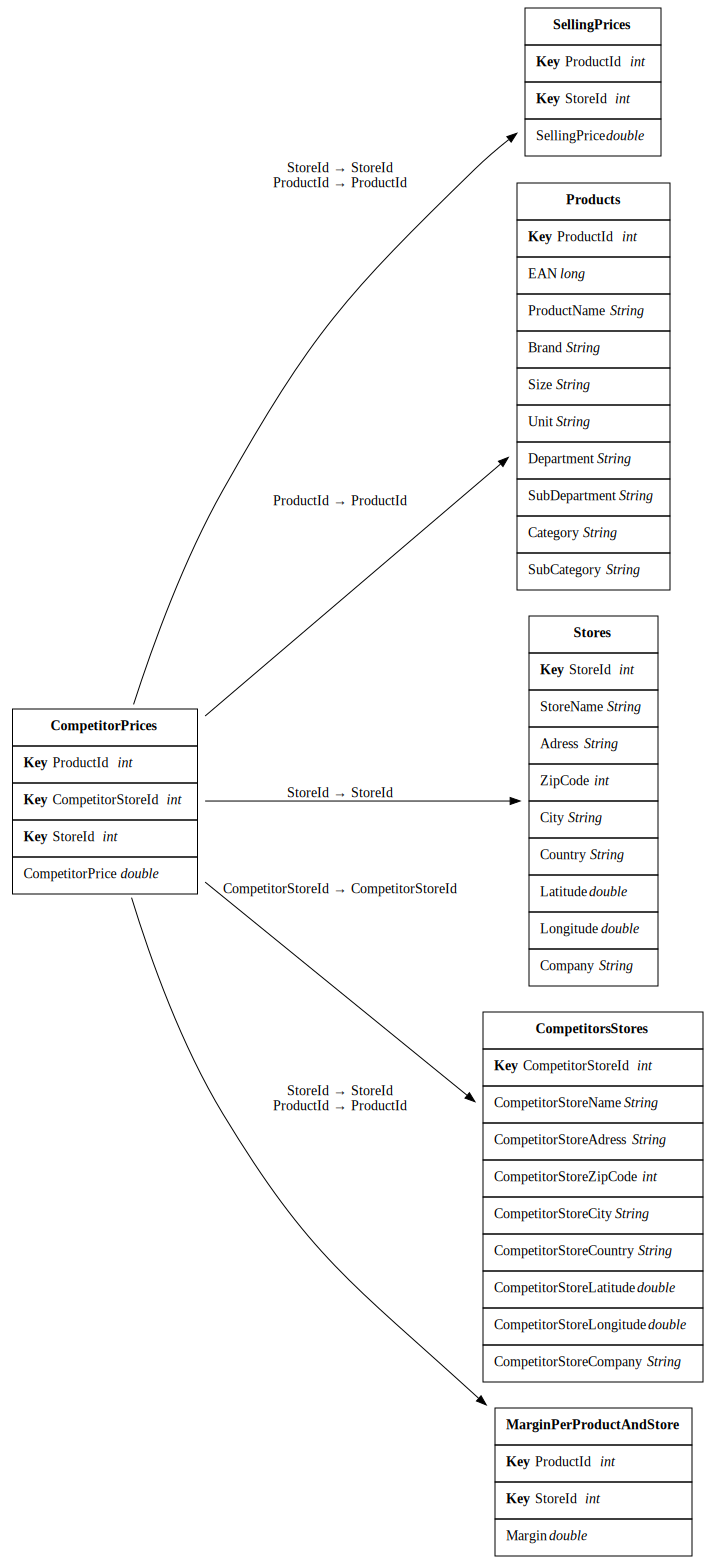

In [20]:
price_index_cube.schema

In [21]:
m = price_index_cube.measures
lvl = price_index_cube.levels

In [22]:
m

Measures()

We can see a _SUM_ and _MEAN_ measure is created columns of type double/float for the base store - CompetitorPrice.  
A _VALUE_ measure is created for columns of type double/float in the other referenced stores.  
Let's create some measures using _Margin_ and _SellingPrice_ from the referenced stores.

In [23]:
m["Margin.SUM"] = tt.agg.sum(margin_per_product_and_store["Margin"])

In [24]:
m["Product Price"] = tt.agg.mean(sellingPrices_store["SellingPrice"])

We see how the weight price index indicator can be achieved in the following cell:

In [25]:
price_index_numerator = tt.agg.sum(
    (m["Product Price"] * m["Margin.SUM"]) / m["CompetitorPrice.MEAN"],
    scope=tt.scope.origin(lvl["ProductId"], lvl["StoreId"]),
)
m["Price Index"] = price_index_numerator / m["Margin.SUM"]

We can now have the price index per store and product.  
As we are currently in sampling mode, let's trigger full data load to do some visualizations.

In [26]:
session.load_all_data()

Let's visualize the price index per store.

In [28]:
price_index_cube.visualize()

Install and enable the atoti JupyterLab extension to see this widget.

#### Extracting Price index for Clustering Analysis

We output the price index per store into a pandas dataframe using an atoti query.  
It will be used as the input for machine learning in the next section. 

In [28]:
price_index_per_store = price_index_cube.query(
    m["Price Index"], levels=[lvl["StoreId"], lvl["StoreName"]]
)
price_index_per_store.head()

,,Price Index
StoreId,StoreName,
1,ActiveViam Store Paris 1er,0.976644
2,ActiveViam Store Paris 15,1.027799
3,ActiveViam Store Paris 18,0.949129
4,ActiveViam Store Paris 12,0.941429
5,ActiveViam Store Paris 16,1.005797


## Stores clustering using price index and competitors number features

In this part we will use the previously calculated features (nr of competitor stores and price index) to generate 5 clusters of stores.  
Since there are five features (Competitors_1_KM, Competitors_5_KM, Competitors_10_KM, Competitors_20_KM, Price Index), a machine learning algorithm such as k-means is appropriate as the human brain will have too much trouble making clusters that have sense.

In the next section we will use those clusters to generate new prices and assess whether we have managed to improve our pricing.

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sc
import seaborn as sns
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import pairwise_distances_argmin

sns.set()  # for plot styling

Merging the features computed in the previous sections:

In [30]:
price_index_per_store.reset_index(inplace=True)
stores_competitors_count_per_area.reset_index(inplace=True)
price_index_per_store = price_index_per_store.drop(columns=["StoreName"])
stores_competitors_count_per_area = stores_competitors_count_per_area.drop(
    columns=["StoreName"]
)
stores_competitors_count_per_area.StoreId = stores_competitors_count_per_area.StoreId.astype(
    int
)

In [31]:
price_index_per_store.dtypes

StoreId          int64
Price Index    float64
dtype: object

In [32]:
stores_features = pd.merge(
    stores_competitors_count_per_area,
    price_index_per_store,
    left_on="StoreId",
    right_on="StoreId",
    how="left",
)

Formatting the features for scikit learn

In [33]:
stores_features = stores_features.set_index("StoreId")
stores_features.head()

,Competitors_1_KM,Competitors_5_KM,Competitors_10_KM,Competitors_20_KM,Price Index
StoreId,,,,,
1,11,51,66,71,0.976644
2,5,46,61,71,1.027799
3,5,36,71,71,0.949129
4,5,31,61,71,0.941429
5,5,36,56,71,1.005797


Chosing the number of clusters

In [34]:
number_of_clusters = 5

And running the clustering algorithm

In [35]:
kmeans = MiniBatchKMeans(number_of_clusters)
kmeans.fit(stores_features)
new_colors = kmeans.cluster_centers_[kmeans.predict(stores_features)]
k_means_labels = pairwise_distances_argmin(stores_features, kmeans.cluster_centers_)
labels = KMeans(number_of_clusters, random_state=0).fit_predict(stores_features)

Using competitors within 1km as an example, we can now analyze the result of the clustering by pair of features using matplotlib as shown below:

Text(0, 0.5, 'Price Index')

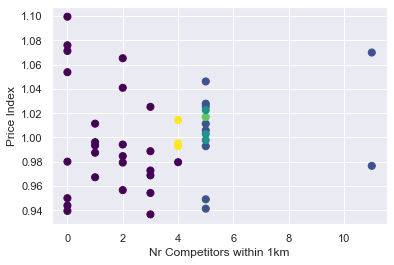

In [36]:
plt.scatter(
    stores_features.loc[:, "Competitors_1_KM"],
    stores_features.loc[:, "Price Index"],
    c=k_means_labels,
    s=50,
    cmap="viridis",
)

plt.xlabel("Nr Competitors within 1km")
plt.ylabel("Price Index")

In the above plot, each color represents a cluster. We can see that clusters seem to be strongly based on the number of competitors rather than on the price index.  
However, to avoid having to plot every couple of features and understand more quickly what our clusters are, we will use seaborn to have a plot of the clustering result for every pair of features.

In [37]:
stores_features["Cluster"] = labels
stores_features.head(5)

,Competitors_1_KM,Competitors_5_KM,Competitors_10_KM,Competitors_20_KM,Price Index,Cluster
StoreId,,,,,,
1,11,51,66,71,0.976644,2
2,5,46,61,71,1.027799,2
3,5,36,71,71,0.949129,2
4,5,31,61,71,0.941429,2
5,5,36,56,71,1.005797,2


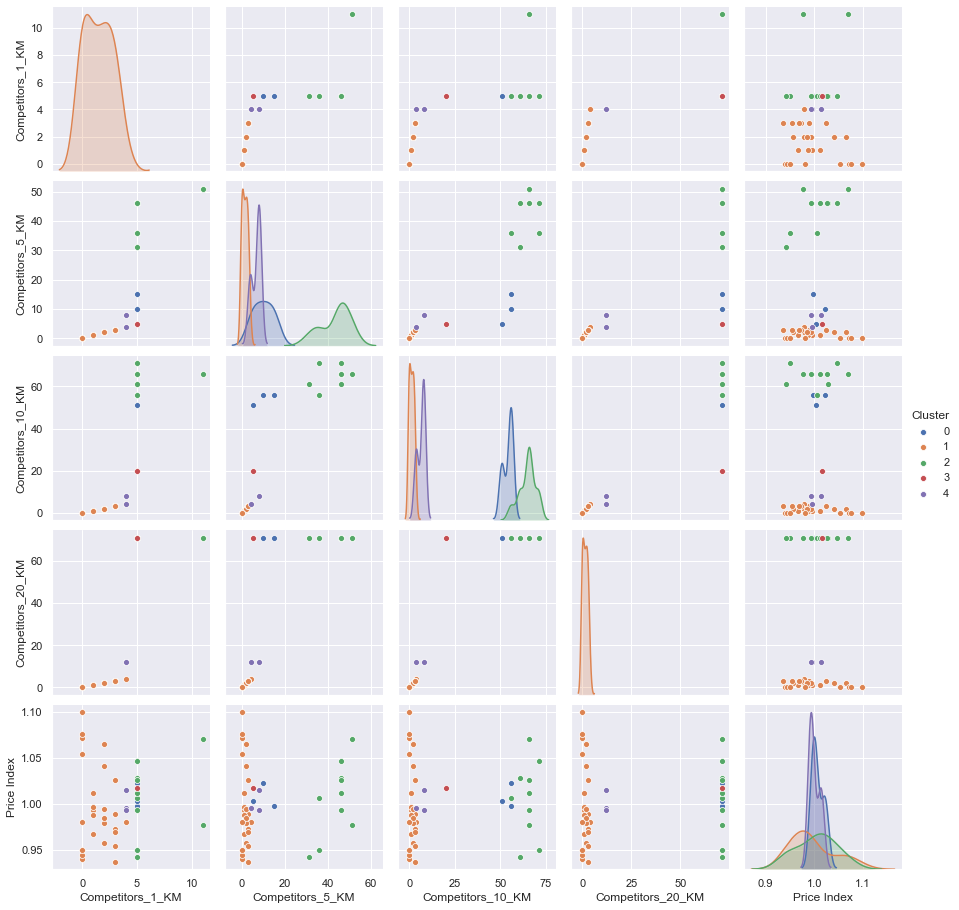

In [38]:
sns.pairplot(data=stores_features, hue="Cluster")

We can have a better understanding of the clusters with the chart above.  
For example clusters 0 and 4 are those with stores that have a price index close to 1, but the stores in cluster 0 have many more competitors in a 10km radius than those of cluster 4.

Continuing this analysis tells us that:
- Cluster 0 contains stores with an average price index (around 1.0) and a lot of competitor stores around.
- Cluster 1 groups the stores with the fewest number of competitor stores around.
- Cluster 2 contains the stores that have the highest number of competitor stores around them.
- Cluster 3 is in between all other clusters. Stores in this cluster have few competitors in a 5km radius, but a lot in a 20km radius.
- Cluster 4 contains stores with an average price index (around 1.0) but few competitor stores around.


## Pricing Simulations around clusters
We will now generate new prices using the previous clusters in order to take into account the different competitiveness constraints of the stores.  

In [39]:
from utils import pricer

The below pricing method tries to reduce the prices if the competitiveness is strong, and on the contrary increase it if there is few competition.  
It is directly using the clusters generated from the previous part.

In [40]:
selling_prices_based_on_clusters = pricer.optimize_prices(
    initial_selling_prices, stores_features
)

Thanks to atoti built-in simulations capabilities, we can easily create a new scenario for the new pricing by directly loading the price-optimised dataframe.  
All the previously defined KPIs, e.g. the price index, will be re-computed on the fly, enabling us to compare the scenarios and their benefits.

In [41]:
sellingPrices_store.scenarios["Selling prices based on clusters"].load_pandas(
    selling_prices_based_on_clusters
)

In [43]:
price_index_cube.visualize()

Install and enable the atoti JupyterLab extension to see this widget.

Let's load the cluster results obtained from the machine learning model into the cube.

In [44]:
clusters_df = stores_features[["Cluster"]].reset_index()
clusters_df.StoreId = clusters_df.StoreId.astype("int32")
cluster_store = session.read_pandas(
    clusters_df, keys=["StoreId"], store_name="Clusters"
)

cluster_store.head(10)

,Cluster
StoreId,
1,2
2,2
3,2
4,2
5,2
6,2
7,2
8,2
9,2


In [45]:
stores_store.join(cluster_store)

With the cluster information added to the cube, we can now visualize the changes in price index for the 5 clusters.

In [47]:
price_index_cube.visualize("Price index optimisation difference")

Install and enable the atoti JupyterLab extension to see this widget.

We can see that the pricing method decreased the price index of stores in clusters that have high competition in order for them to attract more customers.  
On the contrary it increased the prices in stores belonging to low competition clusters in order to maximize margin.